# Filter probes that have too strong secondary structures

In [66]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from nupack import *
import matplotlib.pyplot as plt
import pandas as pd

### 1. Example case

In [3]:
my_model = Model(material='dna', celsius=40, sodium=0.3)

# Define strand species
a = Strand('TAGCGAGGGATAGCACAGCCTGGATAGCAAATTACAAAATCGTAGACTCGCTCG', name='a')
c = Complex([a], name = "c")

In [5]:
t1 = Tube(strands={a:5e-7,}, complexes=SetSpec(max_size=1, include=[c]), name='Tube t1')

# Analyze the tube ensemble
# Since pairs is specified, calculate ensemble pair fractions for the tube ensemble
tube_result = tube_analysis(tubes=[t1], compute=['mfe'], model=my_model)
tube_result

Complex,Pfunc,ΔG (kcal/mol),MFE (kcal/mol)
(a),6.5870e+3,-5.472,-2.884


In [8]:
tube_result[c].mfe[0].energy

-2.8842644691467285

### 2. filter probes that have too high |MFE| using the mSpleen_64_gene probe set as an example

In [64]:
df = pd.read_excel("Spleen_64_gene.xlsx")
df.head()

,Name,Final probe
0,Cd8a_pri_1,AGCAGAAATAGTAGCCTTCGTTTTTATTTTTATCTT
1,Cd8a_pri_2,TCTTGTTGTGGGATGAAGCCTATTTTTATCTT
2,Cd8a_pri_3,GTCCACCTTCTGACCAAGTTTATTTTTATCTT
3,Cd8a_pri_4,CCTCATGGCAGAAAACAGTTTTATTTTTATCTT
4,Cd8a_pri_5,CTAGCGGCTGTGGTAGCAGTATTTTTATCTT


In [70]:
with open("Spleen_64_gene.fasta", "w") as fasta_file:
    for index, row in df.iterrows():
        # Create a SeqRecord object for each row in the DataFrame
        seq_record = SeqRecord(Seq(row['Final probe']), id=row['Name'], description="")
        
        # Write the SeqRecord to the FASTA file
        SeqIO.write(seq_record, fasta_file, "fasta")

In [72]:
Name_list = []
MFE_list = []

# input should be provided in a fasta format
for record in SeqIO.parse("Spleen_64_gene.fasta", "fasta"):
    Name_list.append(record.id)

    a = Strand(str(record.seq), name='a')
    c = Complex([a], name = "c")
    t1 = Tube(strands={a:5e-7,}, complexes=SetSpec(max_size=1, include=[c]), name='Tube t1')
    # Analyze the tube ensemble
    # Since pairs is specified, calculate ensemble pair fractions for the tube ensemble
    tube_result = tube_analysis(tubes=[t1], compute=['mfe'], model=my_model)
    MFE_list.append(tube_result[c].mfe[0].energy)

In [74]:
df = pd.DataFrame({
    'Sequence Name': Name_list,
    'MFE (kcal/mol)': MFE_list})

df_sorted = df.sort_values(by='MFE (kcal/mol)', ascending=True)

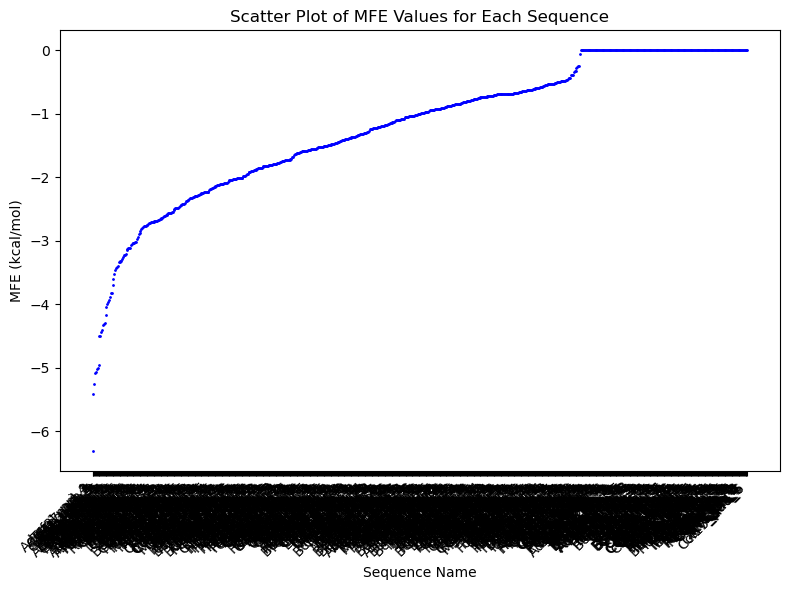

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted["Sequence Name"], df_sorted["MFE (kcal/mol)"], color='blue', s = 1)

plt.xlabel('Sequence Name')
plt.ylabel('MFE (kcal/mol)')
plt.title('Scatter Plot of MFE Values for Each Sequence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [94]:
df_sorted[df_sorted["MFE (kcal/mol)"] < -5]

,Sequence Name,MFE (kcal/mol)
225,Adgre1_pri_4,-6.306668
522,Tcf3_pad_3,-5.410033
211,Ccr7_pri_2,-5.251289
613,Csf1r_pad_4,-5.090265
528,Ikzf1_pad_3,-5.075590
482,Lyl1_pad_5,-5.022033
639,Sirpa_pad_4,-5.010344


Probes with |MFE| > 4 kcal/mol have very strong secondary structures and should be filtered out.

**Adgre1_pri_4**
<img src="Adgre1_pri_4.svg" alt="Adgre1_pri_4" width="500"/>

**Csf1r_pad_4**
<img src="Csf1r_pad_4.svg" alt="Adgre1_pri_4" width="500"/>

In [118]:
df_sorted[(df_sorted["MFE (kcal/mol)"] > -4) & (df_sorted["MFE (kcal/mol)"] < -3)]

,Sequence Name,MFE (kcal/mol)
629,Itgam_pad_6,-3.996428
403,Il2ra_pad_4,-3.967613
601,Adgre1_pad_4,-3.929803
461,Gata3_pad_2,-3.884935
605,Cd68_pad_2,-3.827590
376,Cd8a_pad_1,-3.823259
653,Cd79a_pad_6,-3.689579
228,Cd68_pri_1,-3.596523
535,Runx1_pad_4,-3.530393
286,Cd22_pri_3,-3.453451


Probes with 4 > |MFE| > 2.5 kcal/mol have some secondary structures. Can be filtered depending on availability of other probes targeting the same gene.

**Cd8a_pad_1**
<img src="Cd8a_pad_1.svg" alt="Adgre1_pri_4" width="500"/>

**Cd3g_pri_5**
<img src="Cd3g_pri_5.svg" alt="Adgre1_pri_4" width="500"/>

In [132]:
df_sorted[(df_sorted["MFE (kcal/mol)"] > -2.5) & (df_sorted["MFE (kcal/mol)"] < -2.4)]

,Sequence Name,MFE (kcal/mol)
532,Runx1_pad_1,-2.498670
633,Flt3_pad_4,-2.487344
698,Irf4_pad_3,-2.480250
609,Cd68_pad_6,-2.477673
328,H2-Aa_pri_3,-2.476855
77,Hes1_pri_6,-2.463060
368,Ccr4_pri_5,-2.459095
505,Mef2c_pad_4,-2.442940
628,Itgam_pad_5,-2.439418
477,Ets1_pad_6,-2.428425


Probes with |MFE| < 2.5 have weak secondary structure and may be considered innocuous.

**Cd68_pad_6**
<img src="Cd68_pad_6.svg" alt="Adgre1_pri_4" width="500"/>